<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/pymc3/WellsPerRig2Hiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from google.colab import drive
import os
import sqlite3
import pymc as pm
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import rcParams
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import gaussian_kde
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload() # rigFile varZyren\Jozef wd-workDays wpr-wells/rig/month

Saving rigFile.csv to rigFile.csv


In [3]:
df = pd.read_csv('rigFile.csv')
df[df['RigID_idx'] == 0].head()

,Unnamed: 0,RigID_idx,wd,wpr
0,0,0,21.0,1.447619
1,1,0,53.0,0.573585
388,388,0,33.0,0.921212
1489,1489,0,32.0,0.950000
1517,1517,0,40.0,0.760000


In [5]:
allRigs = df['wd'].dropna().values

hist_data = [allRigs]
group_labels = ['allRigs']
fig = ff.create_distplot(hist_data,group_labels, show_hist=False)
fig.update_layout(title_text='allRigs active rig-days required to drill a well')
fig.show()

In [69]:
#df['RigID_idx'].values
df['wd'][df['RigID_idx'] == 0].values
#len(df['wd'][df['RigID_idx'] == 0].values)

array([21., 53., 33., 32., 40., 40., 26., 21., 27., 22.])

In [70]:
kde = gaussian_kde(df['wd'][df['RigID_idx'] == 0].values)

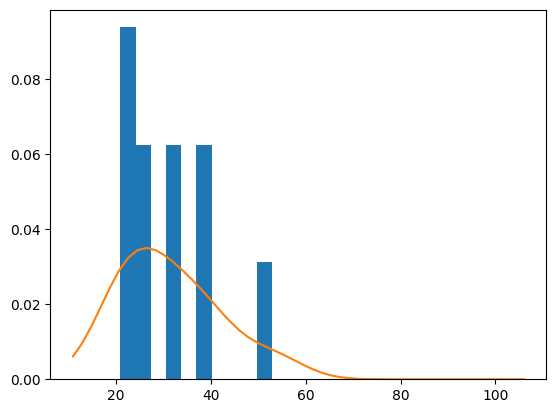

In [72]:
data_space = np.linspace(df['wd'][df['RigID_idx'] == 0].values.min()-10, df['wd'][df['RigID_idx'] == 0].values.max()*2)
evaluated = kde.evaluate(data_space)
plt.hist(df['wd'][df['RigID_idx'] == 0].values, density=True)
plt.plot(data_space, evaluated);

In [76]:
newsamples = kde.resample(6)
newsamples

array([[20.18200191, 27.93681618, 29.04489144, 15.3176359 , 44.53978551,
        40.43855972]])

In [77]:
rigPermian = df[['RigID_idx','wd']].groupby('RigID_idx').agg(['count']).reset_index()
#rigPermian = rigPermian.reset_index()
rigPermian.set_index('RigID_idx', inplace=True)
rigPermian.columns = rigPermian.columns.droplevel()
rigPermian.head()

,count
RigID_idx,
0,10
1,23
2,21
3,5
4,22


In [78]:
kdeBank=[]
for rigx in rigPermian.index:
     if(len(df['wd'][df['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df['wd'][df['RigID_idx'] == 0].values)
     else:
        try:
          kde = gaussian_kde(df['wd'][df['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df['wd'][df['RigID_idx'] == 0].values)
     #print(rigx)
     kdeBank.append([rigx, kde])

In [79]:
 kdeBank = pd.DataFrame(kdeBank)
 kdeBank.columns = ['RigID_idx', 'kde']
 kdeBank.set_index('RigID_idx', inplace=True)

In [80]:
kdeBank.head()

,kde
RigID_idx,
0,<scipy.stats._kde.gaussian_kde object at 0x7d3...
1,<scipy.stats._kde.gaussian_kde object at 0x7d3...
2,<scipy.stats._kde.gaussian_kde object at 0x7d3...
3,<scipy.stats._kde.gaussian_kde object at 0x7d3...
4,<scipy.stats._kde.gaussian_kde object at 0x7d3...


In [81]:
kde = kdeBank.loc[0]['kde']
newsamples = kde.resample(4)
newsamples

array([[23.38489071, 27.26128965, 32.39079543, 21.67511134]])

In [82]:
kdeBank.loc[0]['kde'].resample(4)

array([[44.87471763, 23.7529971 , 33.20795858, 22.39953321]])

In [83]:
len(kdeBank['kde'].values)


221

In [84]:
kde_functions = kdeBank['kde'].values

In [86]:
#kde_functions

In [87]:
# Assign equal weights to each KDE function
weights = np.ones(len(kdeBank['kde'].values)) / len(kdeBank['kde'].values)

In [88]:
combined_kde = lambda x: np.sum(weight * kde_function(x) for weight, kde_function in zip(weights, kde_functions))

In [89]:
# Generate x values for the plot
x_vals = np.linspace(0, 120, 100)

In [90]:
# Evaluate the combined KDE function at x values
y_vals = [combined_kde(x) for x in x_vals]

<ipython-input-88-7fbda9d38e05>:1: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



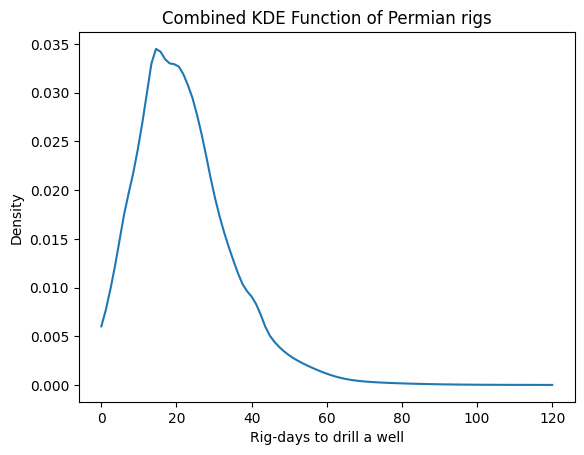

In [91]:
# Plot the combined KDE function
plt.plot(x_vals, y_vals)
plt.xlabel('Rig-days to drill a well')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [ ]:
y_vals

In [93]:
cdf_vals = np.cumsum(y_vals)/np.sum(y_vals)

In [ ]:
cdf_vals

In [95]:
median_idx=np.argmin(np.abs(cdf_vals - 0.5))

In [96]:
median_idx

16

In [97]:
medVal = x_vals[median_idx]

In [98]:
medVal

19.393939393939394

In [99]:
kdeBankWPR=[]
for rigx in rigPermian.index:
     if(len(df['wd'][df['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df['wpr'][df['RigID_idx'] == 0].values)
     else:
        try:
          kde = gaussian_kde(df['wpr'][df['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df['wpr'][df['RigID_idx'] == 0].values)
     #print(rigx)
     kdeBankWPR.append([rigx, kde])

In [100]:
 kdeBankWPR = pd.DataFrame(kdeBankWPR)
 kdeBankWPR.columns = ['RigID_idx', 'kde']
 kdeBankWPR.set_index('RigID_idx', inplace=True)

In [33]:
# Assign equal weights to each KDE function
weightsWPR = np.ones(len(kdeBankWPR['kde'].values)) / len(kdeBankWPR['kde'].values)

In [32]:
#kde_functionsWPR = kdeBankWPR['kde'].values

In [34]:
kde_functionsWPR = kdeBankWPR['kde'].values
combined_kdeWPR = lambda x: np.sum(weight * kde_functionWPR(x) for weight, kde_functionWPR in zip(weightsWPR, kde_functionsWPR))

In [35]:
# Generate x values for the plot
x_valsWPR = np.linspace(0, 4, 40)
# Evaluate the combined KDE function at x values
y_valsWPR = [combined_kdeWPR(x) for x in x_valsWPR]

<ipython-input-34-598c4f16332c>:2: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



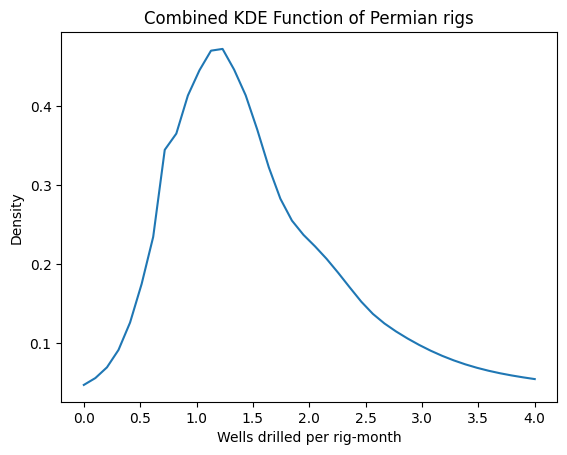

In [36]:
# Plot the combined KDE function
plt.plot(x_valsWPR, y_valsWPR)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [37]:
df6 = df.tail(300)
df6

,Unnamed: 0,RigID_idx,wd,wpr
1928,1928,176,22.0,1.381818
1929,1929,176,15.0,2.026667
1930,1930,173,15.0,2.026667
1931,1931,176,25.0,1.216000
1932,1932,176,13.0,2.338462
...,...,...,...,...
2223,2223,76,28.0,1.085714
2224,2224,99,20.0,1.520000
2225,2225,99,15.0,2.026667
2226,2226,220,33.0,0.921212


In [38]:
rigPermian6 = df6[['RigID_idx','wd']].groupby('RigID_idx').agg(['count']).reset_index()
rigPermian6.set_index('RigID_idx', inplace=True)
rigPermian6.columns = rigPermian6.columns.droplevel()
rigPermian6.head()

,count
RigID_idx,
2,1
3,2
4,2
6,2
7,3


In [39]:
kdeJun23=[]
for rigx in rigPermian6.index:
     if(len(df6['wd'][df6['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == 7].values)
     else:
        try:
          kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == 7].values)
     #print(rigx)
     kdeJun23.append([rigx, kde])

In [40]:
kdeJun23 = pd.DataFrame(kdeJun23)
kdeJun23.columns = ['RigID_idx', 'kde']
kdeJun23.set_index('RigID_idx', inplace=True)
kdeJun23.head()

,kde
RigID_idx,
2,<scipy.stats._kde.gaussian_kde object at 0x7d3...
3,<scipy.stats._kde.gaussian_kde object at 0x7d3...
4,<scipy.stats._kde.gaussian_kde object at 0x7d3...
6,<scipy.stats._kde.gaussian_kde object at 0x7d3...
7,<scipy.stats._kde.gaussian_kde object at 0x7d3...


In [41]:
# Assign equal weights to each KDE function
weightsJun23 = np.ones(len(kdeJun23['kde'].values)) / len(kdeJun23['kde'].values)

In [42]:
kde_functionsJun23 = kdeJun23['kde'].values
combined_kdeJun23 = lambda x: np.sum(weight * kde_function(x) for weight, kde_function in zip(weightsJun23, kde_functionsJun23))

In [43]:
# Generate x values for the plot
x_valsJun23 = np.linspace(0, 4, 40)
# Evaluate the combined KDE function at x values
y_valsJun23 = [combined_kdeJun23(x) for x in x_valsJun23]

<ipython-input-42-de2062ef1200>:2: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



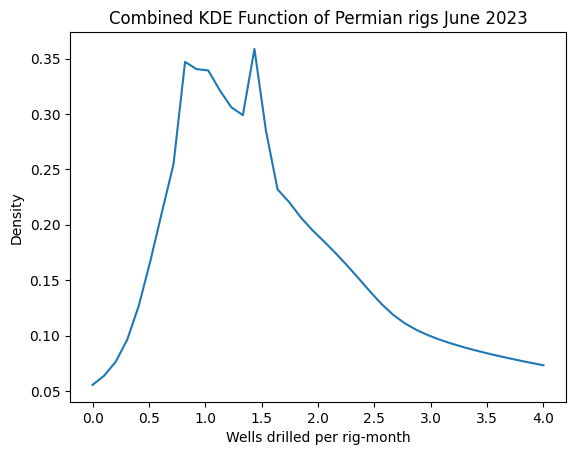

In [44]:
# Plot the combined KDE function
plt.plot(x_valsJun23, y_valsJun23)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs June 2023')
plt.show()

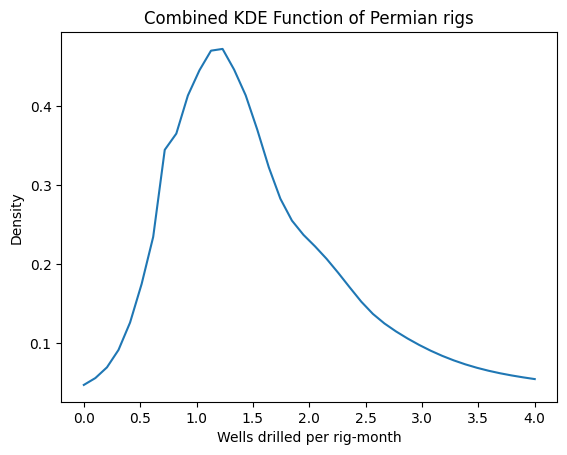

In [45]:
# Plot the combined KDE function
plt.plot(x_valsWPR, y_valsWPR)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [46]:
allRigs = df['wpr'].dropna().values

hist_data = [allRigs]
group_labels = ['allRigs']
fig = ff.create_distplot(hist_data,group_labels, show_hist=False)
fig.update_layout(title_text='allRigs wells per rig-month')
fig.show()

In [47]:
Rig_idx = df.RigID_idx.values
rig_count = len(df.RigID_idx.unique())

pymc

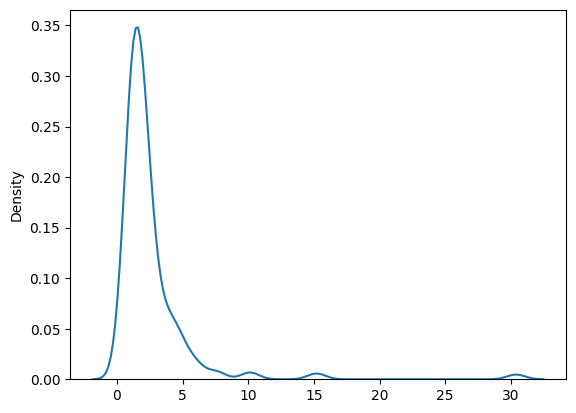

In [48]:
wprData = df['wpr'].dropna().values
sns.kdeplot(wprData);

In [49]:
with pm.Model() as model1:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    wpr = pm.Poisson('wpr', mu, observed=wprData)
    trace1 = pm.sample(1000, tune=1000, init='auto',chains=2)

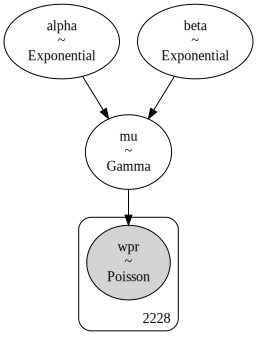

In [53]:
pm.model_to_graphviz(model1)

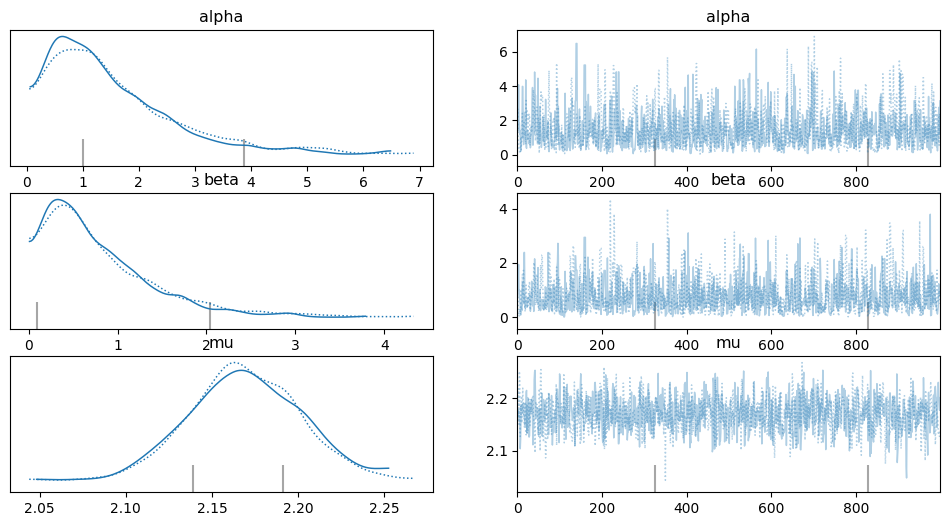

In [54]:
with model1:
    az.plot_trace(trace1)

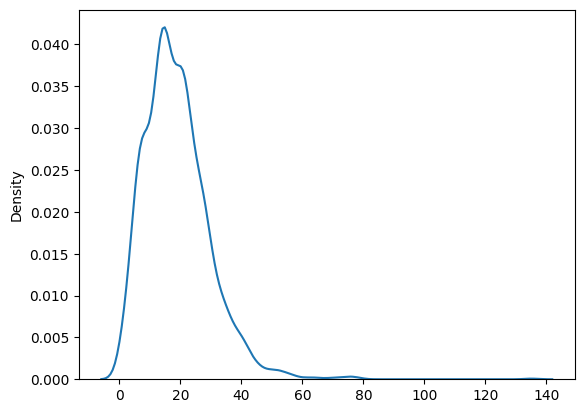

In [55]:
d2wData = df['wd'].dropna().values
sns.kdeplot(d2wData);

In [56]:
with pm.Model() as model2:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    d2w = pm.Poisson('d2w', mu, observed=d2wData)
    trace2 = pm.sample(1000, tune=1000, init='auto',chains=2)

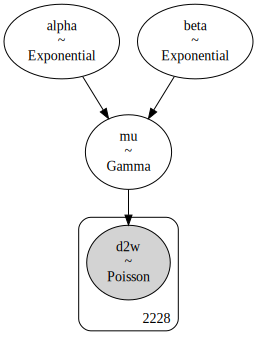

In [57]:
pm.model_to_graphviz(model2)

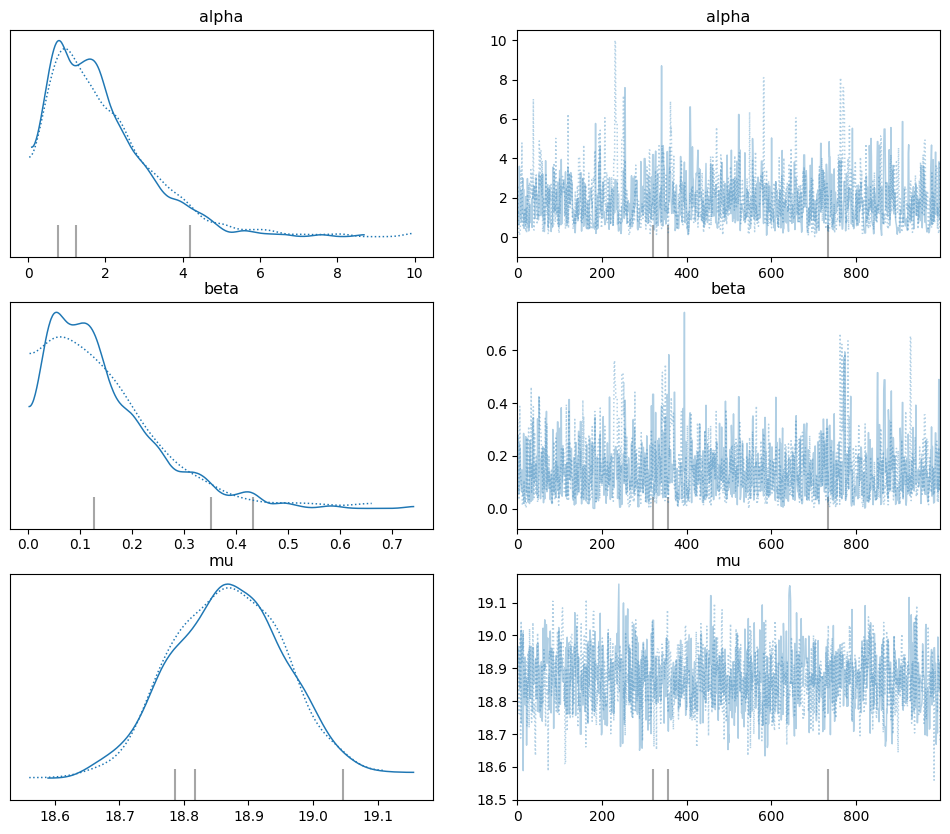

In [58]:
with model1:
    az.plot_trace(trace2, figsize=(12,10))

In [52]:
rigIDs = df['RigID_idx'].unique().tolist()
dicData = {k: v.tolist() for k, v in df.groupby("RigID_idx")["wd"]}

In [ ]:
dicData

In [60]:
df['wd'][df['RigID_idx'] == 17].values

array([24., 39., 27.])

In [53]:
with pm.Model() as model3:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)

    mu = dict()
    rigDays = dict()
    for name, observed in dicData.items():
        mu[name] = pm.Gamma('mu_'+str(name), alpha, beta)
        rigDays[name] = pm.Poisson(str(name), mu[name], observed=observed)

    trace3 = pm.sample(500)

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning:

Loop fusion failed because the resulting node would exceed the kernel argument limit.

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/rewriting/elemwise.py:1028: UserWarning:

Loop fusion failed because the resulting node would exceed the kernel argument limit.



In [54]:
pm.summary(trace3).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.15,0.82,6.51,9.57,0.04,0.03,488.0,661.0,1.00
beta,0.41,0.04,0.32,0.48,0.00,0.00,496.0,623.0,1.00
mu_0,31.14,1.71,27.84,34.12,0.05,0.04,1021.0,839.0,1.00
mu_1,20.91,0.91,19.16,22.50,0.02,0.02,1476.0,653.0,1.01
mu_2,24.16,1.06,22.16,26.17,0.03,0.02,1080.0,729.0,1.00
...,...,...,...,...,...,...,...,...,...
mu_216,31.16,3.09,25.81,36.94,0.09,0.06,1235.0,772.0,1.00
mu_217,17.09,3.56,10.56,23.82,0.08,0.06,1709.0,654.0,1.00
mu_218,21.36,3.74,14.52,28.25,0.11,0.08,1109.0,824.0,1.00
mu_219,25.64,4.22,18.61,34.36,0.12,0.09,1113.0,691.0,1.00


In [105]:
pm.model_to_graphviz(model3)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (223), generating only 20 plots



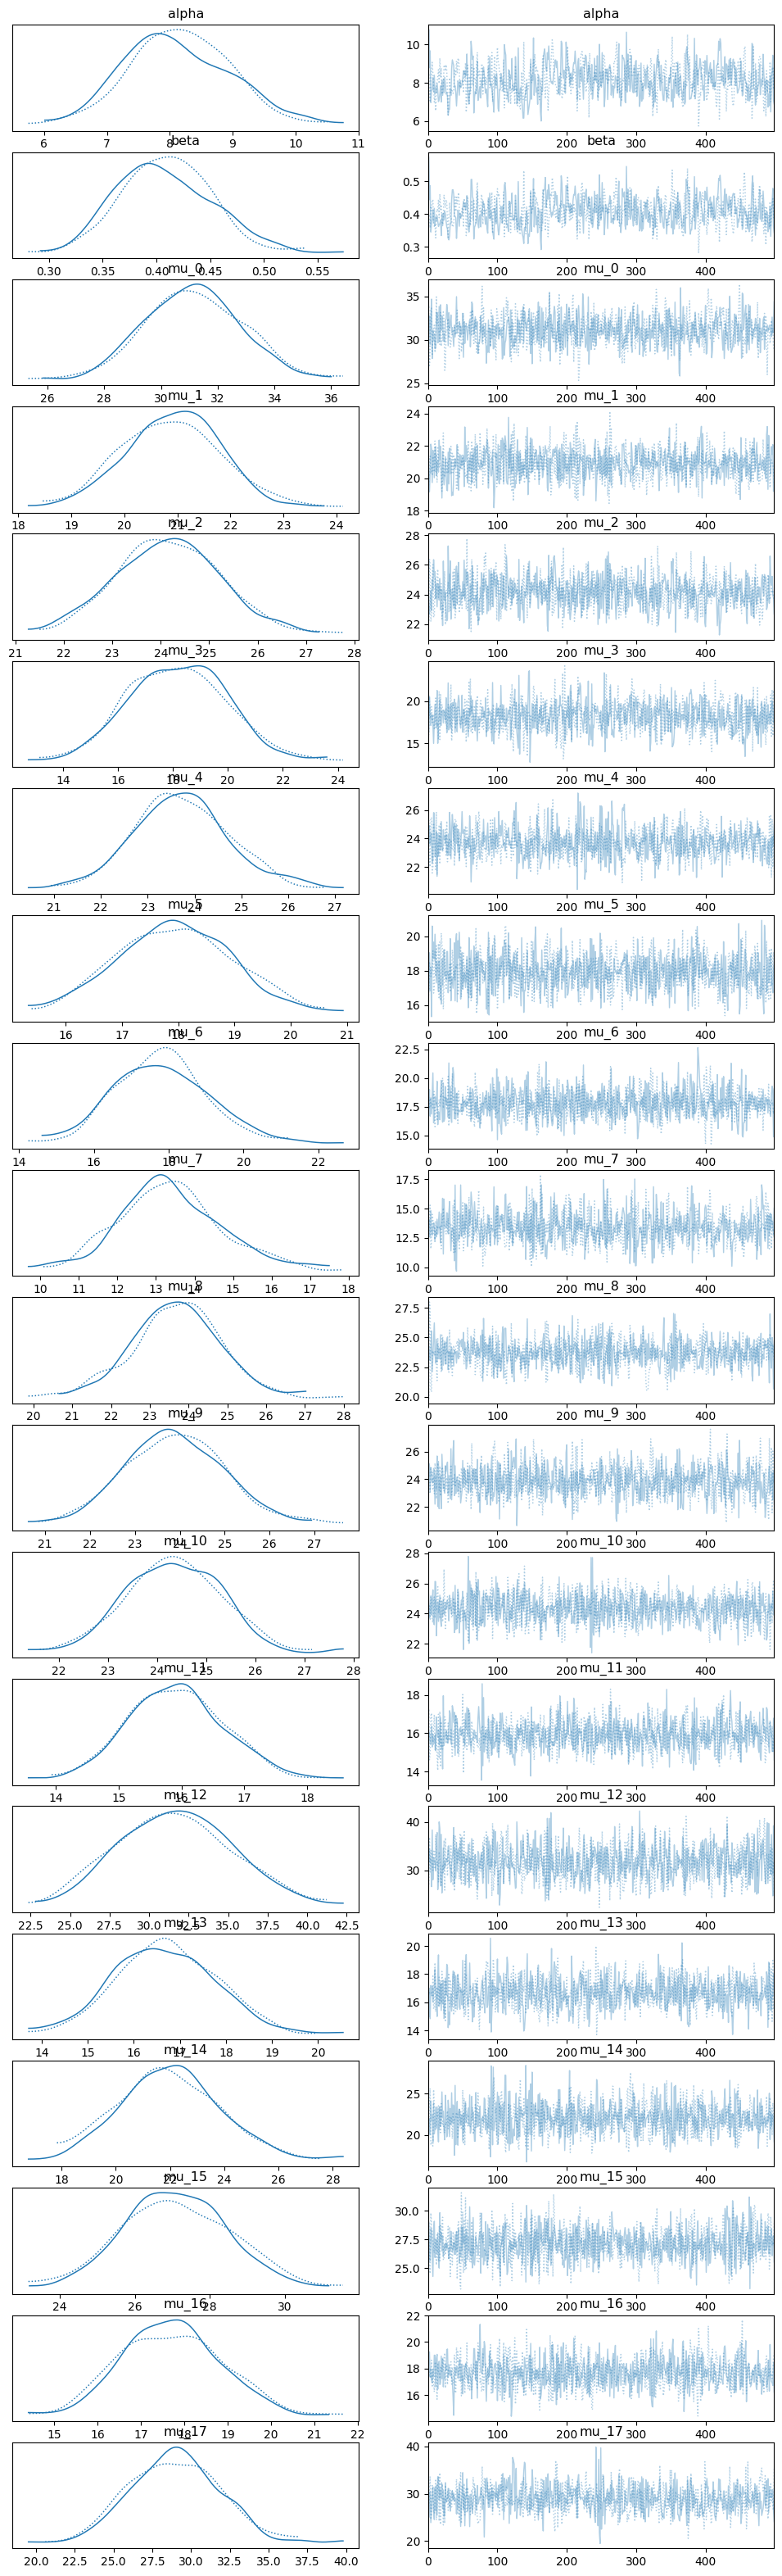

In [102]:
az.plot_trace(trace3, compact=True);